In [1]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import graph_statistics
import utils
from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot, make_rel_error_df, heat_map_from_df)

In [2]:
import matplotlib.pyplot as plt
def plot_rel_error_dict(rel_error_dict, sorted_plot=None, width=1, rowpad=50, colpad=30, fontsize=15, color='grey', save_path=None):
    """ rel_error_dict is a dict of dict of dicts: keys indicate: data sets (outer key), statistics (middle key),
        models (inner key).
    Args:
        rel_error_dict: dict of dict of dicts: keys indicate: data sets (outer key), statistics (middle key),
            models (inner key). Values are the corresponding relative errors.
        sorted_plot: list for 'datasets', 'statistics', and 'models'. Values are the sorted names
            to indicate the order in which things are plotted. If None, plot in order given by rel_error_dict."""
    # Remove annotations and axes
    rc = {"axes.spines.left" : False,
          "axes.spines.right" : False,
          "axes.spines.bottom" : False,
          "axes.spines.top" : False,
          "xtick.bottom" : False,
          "xtick.labelbottom" : False,
          "ytick.labelleft" : False,
          "ytick.left" : False}
    plt.rcParams.update(rc)
    plt.rcParams.update({'font.size': fontsize})

    # Number of datasets, statistics, and models
    first_inner_dict = rel_error_dict[list(rel_error_dict.keys())[0]]
    first_inner_tuple = first_inner_dict[list(first_inner_dict.keys())[0]]
    num_datasets = len(rel_error_dict.keys())
    num_statistics = len(first_inner_dict.keys())
    num_models = len(first_inner_tuple)

    # Make subplots
    fig, axs = plt.subplots(nrows=num_datasets, ncols=num_statistics, sharex=True, sharey=True)
    if sorted_plot is not None:
        row_names, col_names, model_names = sorted_plot
        for i in range(num_datasets):
            for j in range(num_statistics):
                for k in range(num_models):
                    rel_error = rel_error_dict[row_names[i]][col_names[j]][model_names[k]]
                    axs[i, j].bar(x=k*width, height=rel_error, width=.9*width, color=color)
        # Set titles
        for ax, col in zip(axs[0], col_names):
            ax.set_title(col, rotation=-45, pad=colpad, size='large')
        for ax, row in zip(axs[:,0], row_names):
            ax.set_ylabel(row, rotation=0, labelpad=rowpad, size='large')
    else:                    
        for i, (dataset, statistics_dict) in enumerate(rel_error_dict.items()):
            for j, (stat, val) in enumerate(statistics_dict.items()):
                for k, rel_error in enumerate(val.values()):
                    axs[i, j].bar(x=k*width, height=rel_error, width=.9*width, color=color)
        # Set titles
        rows = list(rel_error_dict.keys())
        cols = list(first_inner_dict.keys())
        for ax, col in zip(axs[0], cols):
            ax.set_title(col, rotation=-45, pad=colpad, size='large')
        for ax, row in zip(axs[:,0], rows):
            ax.set_ylabel(row, rotation=0, labelpad=rowpad, size='large')

    fig.tight_layout()
    plt.show()
    if save_path:                                       
        plt.savefig(fname=save_path, bbox_inches='tight')  
    return

def rename_keys(rel_error_dict, row_names, col_names):
    for name, new_name in row_names.items():
        if name in rel_error_dict.keys():
            rel_error_dict[new_name] = rel_error_dict.pop(name)
    for key, inner_dict in rel_error_dict.items():
        for name, new_name in col_names.items():
            if name in inner_dict.keys():
                rel_error_dict[key][new_name] = rel_error_dict[key].pop(name)
    return rel_error_dict

In [3]:
rel_error_dict = {'Data set A':{'Stat 1':{'M1':.5, 'M2':1, 'M3':.5}, 'Stat 2':{'M1':.5, 'M2':1, 'M3':2}, 'Stat 3':{'M1':.5, 'M2':1, 'M3':2}}, 
                'Data set B':{'Stat 1':{'M1':.5, 'M2':1, 'M3':2}, 'Stat 2':{'M1':.5, 'M2':1, 'M3':2}, 'Stat 3':{'M1':.5, 'M2':1, 'M3':2}}}

row_names = {'Data set A' : 'A'}
col_names = {'Stat 1': '1', 'Stat 2' : '2', 'x' : 'y'}

rel_error_dict = rename_keys(rel_error_dict, row_names, col_names)

sorted_plot=(['A', 'Data set B'], ['1', '2', 'Stat 3'], ['M2', 'M1', 'M3'])

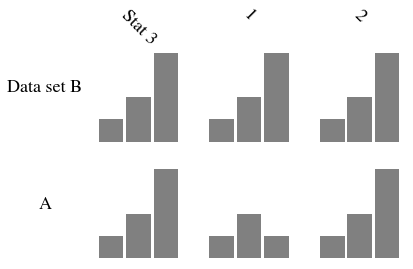

In [5]:
plot_rel_error_dict(rel_error_dict)

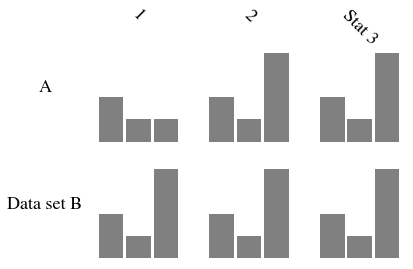

In [6]:
plot_rel_error_dict(rel_error_dict, sorted_plot=sorted_plot)

In [9]:
def make_rel_error_dict(path, datasets, models, statistic_fns, overlap, original_graphs, link_prediction=True):
    """ Make a table/ heatmap that compares the relative error of two models at a specified edge overlap 
    for a list of datasets and a list of statistics. Always computes error of first model minus
    error of second model.
    Parameters
    ----------
    datasets: List of strings (names of datasets)
    models: List. Values are model names.
    statistic_fns: Dictionary. Keys are statistic names, values are functions used to compute the statistics.
    overlap: Float. Consider first graphs of each trial that achieves this overlap.
    original_graphs: Dictionary. Keys are datasets, values are corresponding train graphs.

    Returns
    -------
    rel_error_dict. Dictionary. dict of dict of dicts: keys indicate: data sets (outer key), 
                     statistics (middle key), models (inner key). Values are the corresponding relative errors.
    """
    # Create relative error dict and original statistics dict
    rel_error_dict = {}
    for dataset in datasets:
            statistic_keys = list(statistic_fns.keys())
            if link_prediction:
                statistic_keys += ['ROC-AUC Score', 'Average Precision']                                   
            rel_error_dict[dataset] = dict.fromkeys(statistic_keys, {})                                           
    original_statistics = dict.fromkeys(datasets, None)
    # Fill entries of rel_error_dict (datasets-statistic_fns-model: rel_error)
    for dataset in datasets:
        for model in models:
            # Check if original statistic is computed. If not, compute it
            if original_statistics[dataset] is None:
                original_statistics[dataset] = compute_original_statistics(original_graphs[dataset],
                                                                           statistic_fns)
                if link_prediction:                                           
                    original_statistics[dataset]['ROC-AUC Score'] = 1
                    original_statistics[dataset]['Average Precision'] = 1                                           
            # Extract statistics for specified model, dataset, and edge overlap
            eval_model_dataset = Evaluation(experiment_root=os.path.join(path, dataset, model),
#                                            f'../logs/rel_error_table/{dataset}/{model}/'
                                            statistic_fns=statistic_fns)
            _, overlap_statistics = eval_model_dataset.get_specific_overlap_graph(target_overlap=overlap)
            # Compute relative error for all statistics
            list_of_statistics = list(statistic_fns.keys())
            if link_prediction:
                list_of_statistics = list_of_statistics + ['ROC-AUC Score', 'Average Precision']                                 
            for statistic in list_of_statistics:                                 
                rel_errors = []
                for trial in overlap_statistics.keys():
                    if not math.isnan(overlap_statistics[trial][statistic]):                                            
                        rel_errors.append(np.abs(overlap_statistics[trial][statistic]-original_statistics[dataset][statistic]))
                rel_error = np.array(rel_errors).mean() / original_statistics[dataset][statistic]
                rel_error_dict[dataset][statistic][model] = np.abs(rel_error)
            # Compute average edge overlaps and print them
            avg_overlap = 0
            for trial in overlap_statistics.keys():
                avg_overlap += overlap_statistics[trial]['Edge Overlap (%)'] / len(overlap_statistics.keys())
            print(f'Avg. overlap for {dataset}:{model} is {avg_overlap}')
    return rel_error_dict